# Solar radiation prediction

### Dataset information

These datasets are meteorological data from the HI-SEAS weather station from four months (September through December 2016) between Mission IV and Mission V.

For each dataset, the fields are:
- A row number (1-n) useful in sorting this export's results
- The UNIX time_t date (seconds since Jan 1, 1970). Useful in sorting this export's results with other export's results
- The date in yyyy-mm-dd format
- The local time of day in hh:mm:ss 24-hour format
- The numeric data, if any (may be an empty string)
- The text data, if any (may be an empty string)

The units of each dataset are:
- Solar radiation: watts per meter^2
- Temperature: degrees Fahrenheit
- Humidity: percent
- Barometric pressure: Hg
- Wind direction: degrees
- Wind speed: miles per hour
- Sunrise/sunset: Hawaii time

#### Importing libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

### Loading the data

In [2]:
data_dir = os.path.join(os.getcwd(), 'data')
solar_pred_path = os.path.join(data_dir, 'SolarPrediction.csv')
df = pd.read_csv(solar_pred_path)

#### First look at the data

In [3]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [4]:
print(f'There are {df.shape[0]} examples.')
print(f'There are {df.shape[1] - 1} features.')
print(f'There are {df.duplicated().sum()} duplicated examples')

There are 32686 examples.
There are 10 features.
There are 0 duplicated examples


In [5]:
df.info()
print('-----------------------------------')
print(f'There are {np.sum(df.isnull().sum())} missing values in the data.')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB
-----------------------------------
There are 0 missing values in the data.


In [6]:
df.describe().drop('UNIXTime', axis = 1).T

,count,mean,std,min,25%,50%,75%,max
Radiation,32686.0,207.124697,315.916387,1.11,1.2300,2.66,354.235,1601.26
Temperature,32686.0,51.103255,6.201157,34.00,46.0000,50.00,55.000,71.00
Pressure,32686.0,30.422879,0.054673,30.19,30.4000,30.43,30.460,30.56
Humidity,32686.0,75.016307,25.990219,8.00,56.0000,85.00,97.000,103.00
WindDirection(Degrees),32686.0,143.489821,83.167500,0.09,82.2275,147.70,179.310,359.95
Speed,32686.0,6.243869,3.490474,0.00,3.3700,5.62,7.870,40.50


### Data wrangling

In [7]:
# Keep original dataframe in case
df_new = df.copy()

# Keep only the date from data column, as information on time in contained in Time column
df_new['Data'] = df_new['Data'].str.split(' ').str[0]

In [8]:
# Converting dates and times to datetime format
df_new['Datetime'] = pd.to_datetime(df_new['Data'] + ' ' + df_new['Time'])
df_new['SunRise_datetime'] = pd.to_datetime(df_new['TimeSunRise'])
df_new['SunSet_datetime'] = pd.to_datetime(df_new['TimeSunSet'])

In [9]:
# Extracting information from Data and Time column
df_new['Minute of day'] = df_new['Datetime'].dt.minute
df_new['Hour of day'] = df_new['Datetime'].dt.hour
df_new['Day of year'] = df_new['Datetime'].dt.day_of_year
df_new['Week of year'] = df_new['Datetime'].dt.weekday
df_new['Month of year'] = df_new['Datetime'].dt.month

# Extracting information from TimeSunRise and TimeSunSet column
# Calculating the duration of sun exposition in seconds
df_new['Daylength'] = (df_new['SunSet_datetime'] - df_new['SunRise_datetime']).dt.total_seconds()


In [10]:
df_processed = df_new.drop(['UNIXTime', 'Data', 'Time', 'TimeSunRise', 'TimeSunSet', 'SunRise_datetime', 'SunSet_datetime' ], axis = 1)
df_processed.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Datetime,Minute of day,Hour of day,Day of year,Week of year,Month of year,Daylength
0,1.21,48,30.46,59,177.39,5.62,2016-09-29 23:55:26,55,23,273,3,9,43200.0
1,1.21,48,30.46,58,176.78,3.37,2016-09-29 23:50:23,50,23,273,3,9,43200.0
2,1.23,48,30.46,57,158.75,3.37,2016-09-29 23:45:26,45,23,273,3,9,43200.0
3,1.21,48,30.46,60,137.71,3.37,2016-09-29 23:40:21,40,23,273,3,9,43200.0
4,1.17,48,30.46,62,104.95,5.62,2016-09-29 23:35:24,35,23,273,3,9,43200.0


In [11]:
df_processed.describe().T

,count,mean,min,25%,50%,75%,max,std
Radiation,32686.0,207.124697,1.11,1.23,2.66,354.235,1601.26,315.916387
Temperature,32686.0,51.103255,34.0,46.0,50.0,55.0,71.0,6.201157
Pressure,32686.0,30.422879,30.19,30.4,30.43,30.46,30.56,0.054673
Humidity,32686.0,75.016307,8.0,56.0,85.0,97.0,103.0,25.990219
WindDirection(Degrees),32686.0,143.489821,0.09,82.2275,147.7,179.31,359.95,83.1675
Speed,32686.0,6.243869,0.0,3.37,5.62,7.87,40.5,3.490474
Datetime,32686,2016-11-01 14:41:04.944808192,2016-09-01 00:00:08,2016-10-03 16:01:37.500000,2016-11-01 08:47:49.500000,2016-11-29 18:28:48,2016-12-31 23:55:01,NaN
Minute of day,32686.0,27.556691,0.0,15.0,30.0,45.0,57.0,17.268507
Hour of day,32686.0,11.557425,0.0,6.0,12.0,18.0,23.0,6.912034
Day of year,32686.0,306.110965,245.0,277.0,306.0,334.0,366.0,34.781367


### Exploratory Data Analysis

In [12]:
# There should be only numerical features, let's check
num_features = [col for col in df_processed.columns if pd.api.types.is_numeric_dtype(df_processed[col])]
cat_features = [col for col in df_processed.columns if pd.api.types.is_object_dtype(df_processed[col])]

print(f'Numerical features : {num_features}')
print(f'Categorical features : {cat_features}')

Numerical features : ['Radiation', 'Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed', 'Minute of day', 'Hour of day', 'Day of year', 'Week of year', 'Month of year', 'Daylength']
Categorical features : []


In [13]:
df_grouped_hour = df_processed.groupby('Hour of day').mean()
df_grouped_day = df_processed.groupby('Day of year').mean()
#df_grouped_week = df_processed.groupby('Week of year').mean()
df_grouped_month = df_processed.groupby('Month of year').mean()

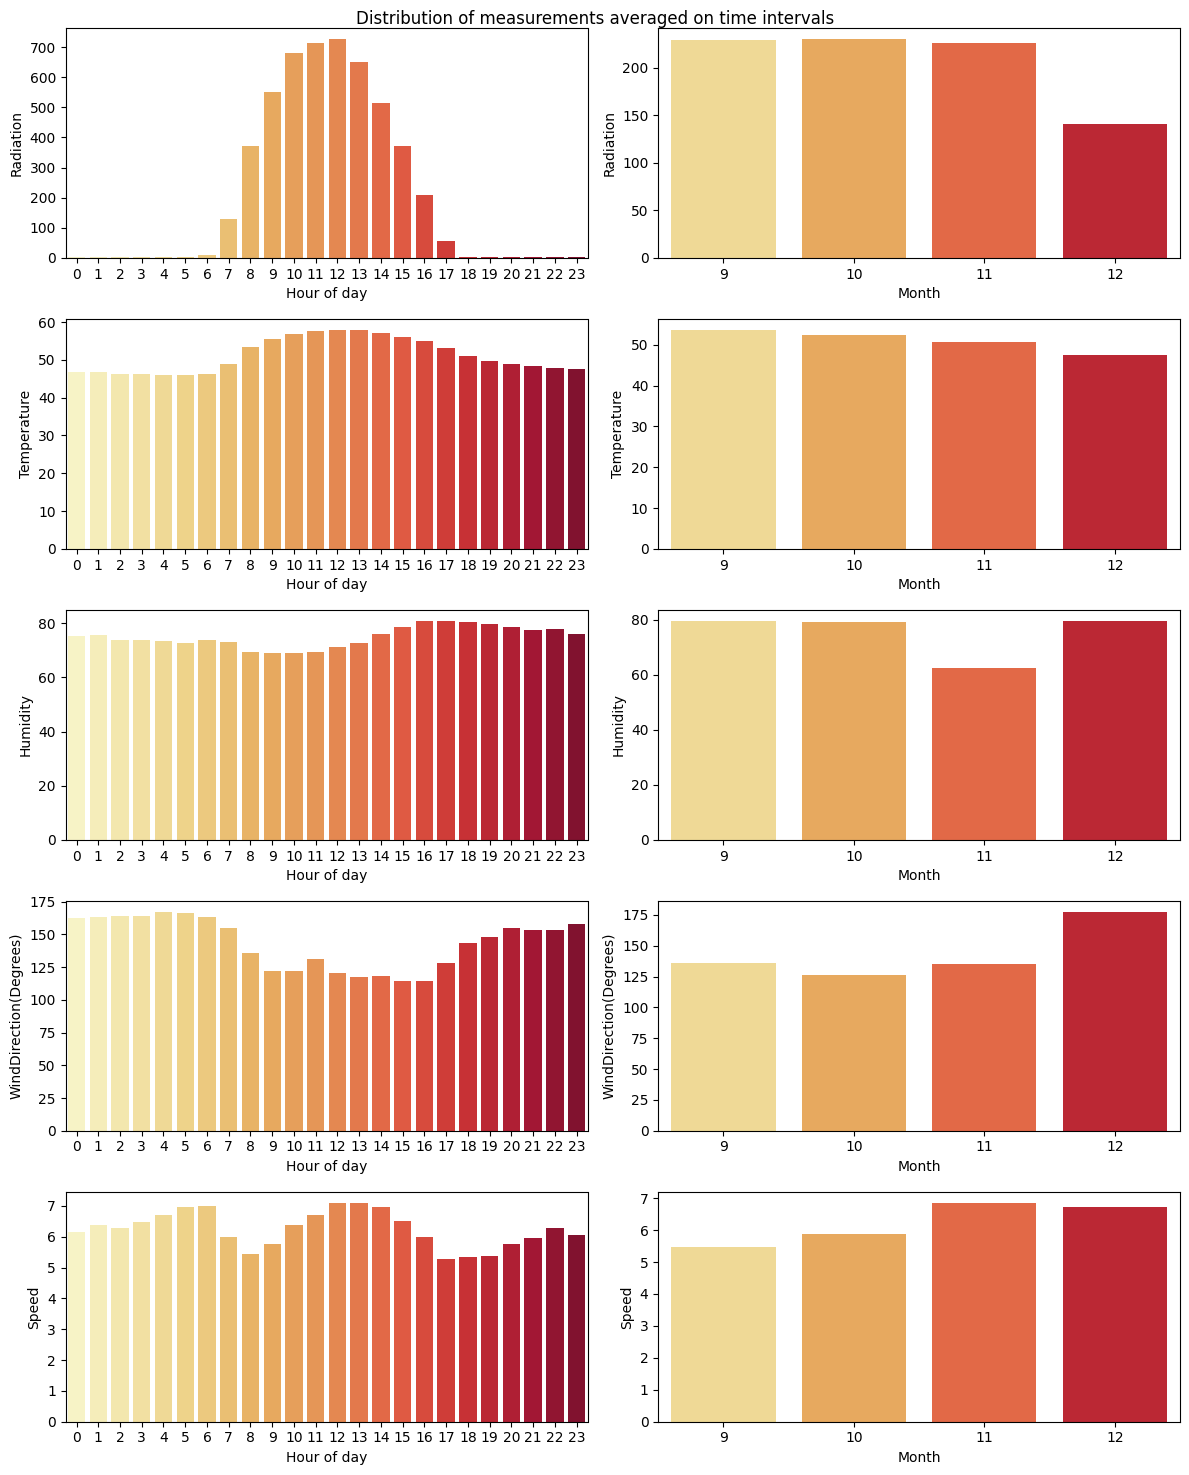

In [14]:
# 6 physical measurements features to plot on time interval
fig, axs = plt.subplots(5, 2, figsize = (12,15))
measurements = ['Radiation', 'Temperature', 'Humidity', 'WindDirection(Degrees)', 'Speed']
color_palette = "YlOrRd"

for i, measurement in enumerate(measurements):
    sns.barplot(data = df_grouped_hour, x = 'Hour of day', y = measurement, ax = axs[i, 0], palette = color_palette)
    sns.barplot(data = df_grouped_month, x = 'Month of year', y = measurement, ax = axs[i, 1], palette = color_palette)
    axs[i, 1].set_xlabel('Month')
    axs[i, 0].set_ylabel(measurement)

plt.suptitle('Distribution of measurements averaged on time intervals')
plt.tight_layout()  
plt.show()

Let us pairplot the features over time intervals to get a better sense of dependencies and relationships between them.

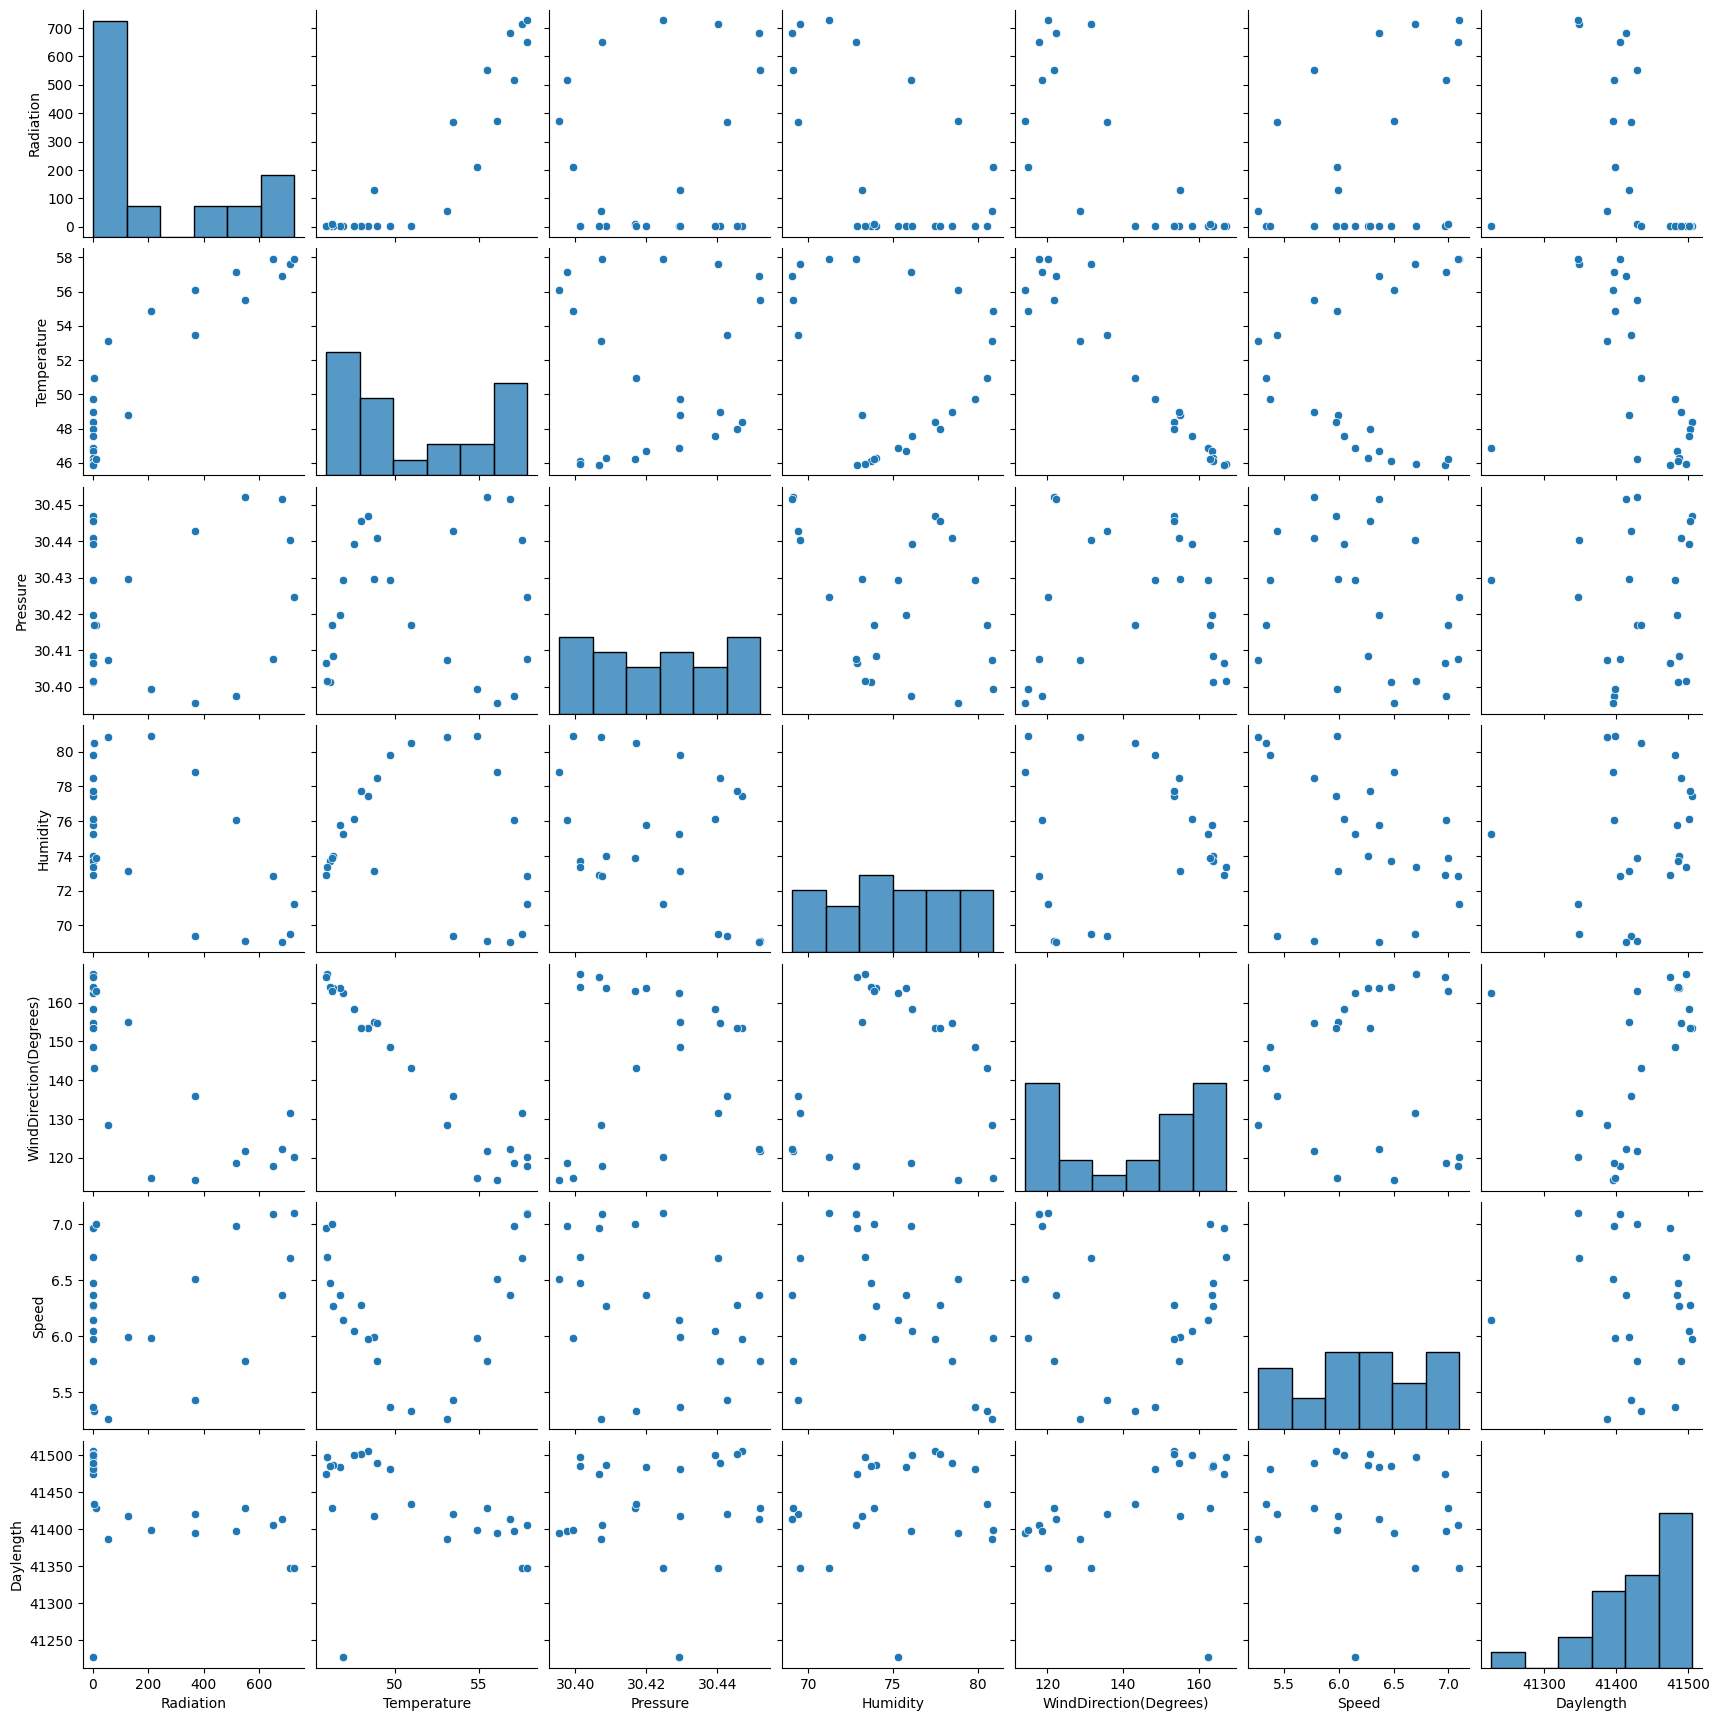

In [15]:
to_pair_plot = ['Radiation', 'Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed', 'Daylength']
# Pair plot with values averaged on hours
sns.pairplot(df_grouped_hour[to_pair_plot])

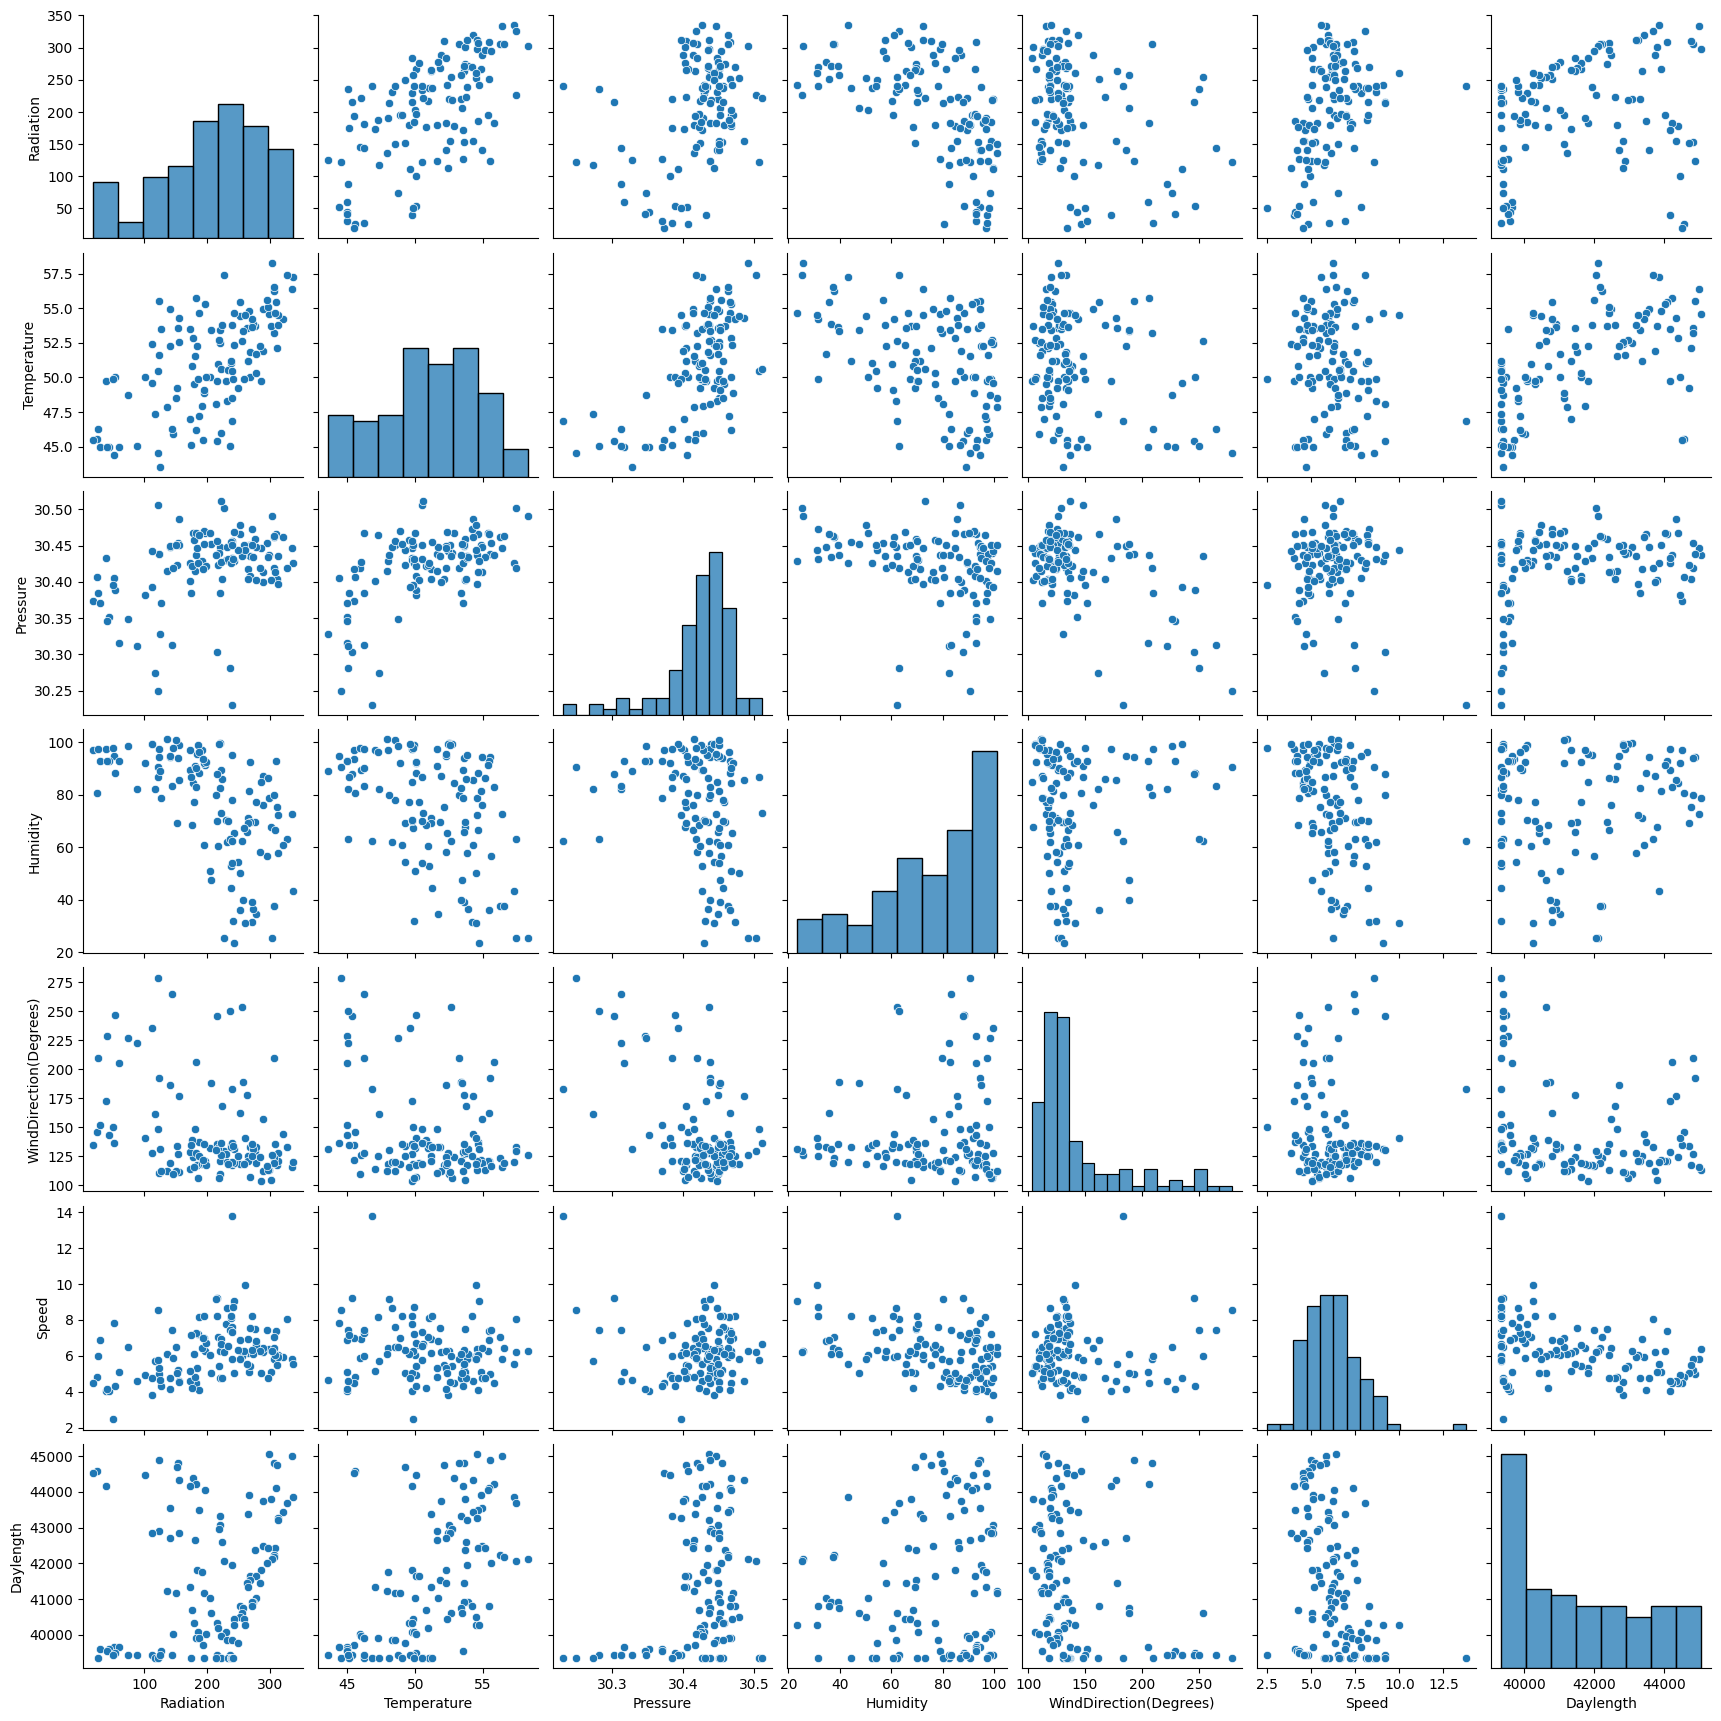

In [16]:
# Pair plot with values averaged on days
sns.pairplot(df_grouped_day[to_pair_plot])

- Features Temperature and Speed seem to have a linear relationships with the target Radiation, althought the points are quite scattered.
- Feature Humidity seems to share a non linear relationship with the target

No additional conclusions can be drawn from the plots only.


### Feature selection

<Axes: >

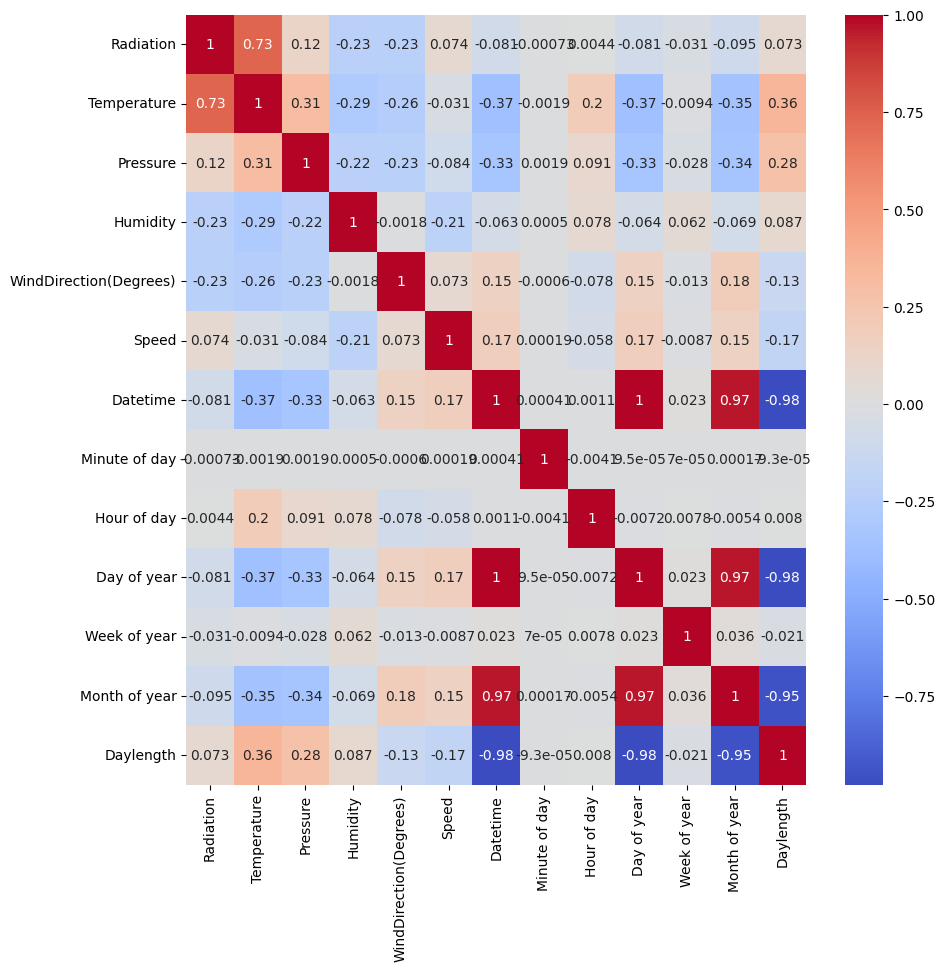

In [17]:
plt.figure(figsize = (10,10))
sns.heatmap(df_processed.corr(), annot = True, cmap = 'coolwarm')

- Our intuition about the correlation between Radiation and Temperature / Radiation and Humidity seems confirmed by the correlation matrix
- Target appears to have correlation with WindDirection(Degrees) as well, and weaker correlation with Pressure

For now, we will remove a few features and see how the first models will perform.

In [18]:
features_to_remove = ['Minute of day', 'Week of year', 'Datetime']
df_reduced = df_processed.drop(features_to_remove, axis = 1)

In [19]:
df_reduced.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Hour of day,Day of year,Month of year,Daylength
0,1.21,48,30.46,59,177.39,5.62,23,273,9,43200.0
1,1.21,48,30.46,58,176.78,3.37,23,273,9,43200.0
2,1.23,48,30.46,57,158.75,3.37,23,273,9,43200.0
3,1.21,48,30.46,60,137.71,3.37,23,273,9,43200.0
4,1.17,48,30.46,62,104.95,5.62,23,273,9,43200.0


### Model selection

Data is highly non linear, so we will try out some models that perform well on such data (simple Linear Regression is excluded).

In [20]:
from sklearn.model_selection import train_test_split
X = df_reduced.drop('Radiation', axis = 1)
y = df_reduced['Radiation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [21]:
# SVR, RandomForestRegressor, gradient boosting ?
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor

models = {'Decision Tree' : DecisionTreeRegressor(), 'Random Forest': RandomForestRegressor(), 'Gradient boosting' : LGBMRegressor()}


In [22]:
for _, model in models.items():
    model.fit(X_train,y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 685
[LightGBM] [Info] Number of data points in the train set: 26148, number of used features: 9
[LightGBM] [Info] Start training from score 208.044780


In [23]:
from sklearn.metrics import root_mean_squared_error, r2_score

def model_eval(model_name,model, X_test, y_test):
    metrics = {}
    y_pred = model.predict(X_test)
    r_mse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    metrics[model_name] = {'Root Mean Squared Error' : np.round(r_mse,3), 'R2 score' : np.round(r2,3)}
    print(metrics)
    return metrics

for model_name,model in models.items():
    model_eval(model_name, model, X_test, y_test)


{'Decision Tree': {'Root Mean Squared Error': 116.903, 'R2 score': 0.862}}
{'Random Forest': {'Root Mean Squared Error': 86.455, 'R2 score': 0.925}}
{'Gradient boosting': {'Root Mean Squared Error': 88.013, 'R2 score': 0.922}}


<Axes: xlabel='importance', ylabel='feature'>

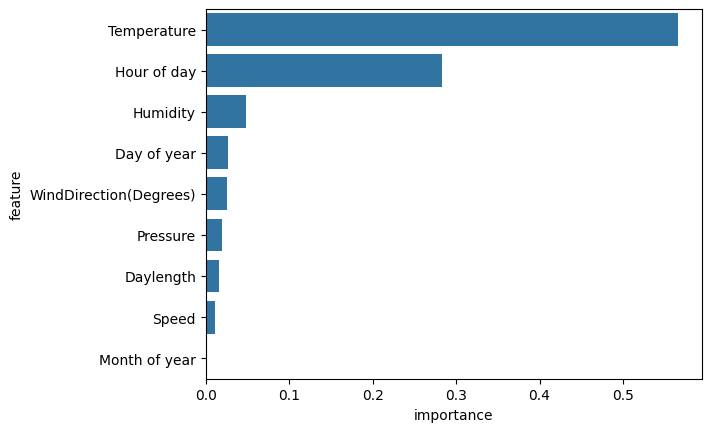

In [24]:
importances = models['Random Forest'].feature_importances_
feature_importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

sns.barplot(data = feature_importance_df, x = 'importance', y = 'feature')

The two main relevant features to predict solar radiations are Temperature and Hour of the day.

Let us see if removing additional features improves the models performances :

In [25]:
X_train_reduced = X_train.drop(['Month of year', 'Speed', 'Day of year', 'Pressure', 'WindDirection(Degrees)'], axis = 1)
X_test_reduced = X_test.drop(['Month of year', 'Speed', 'Day of year', 'Pressure','WindDirection(Degrees)'], axis = 1)

In [26]:
models_reduced = {'Decision Tree' : DecisionTreeRegressor(), 
          'Random Forest': RandomForestRegressor(), 
          'Gradient boosting' : LGBMRegressor()}

for _, model in models_reduced.items():
    model.fit(X_train_reduced,y_train)

print('-----------------------------------------------------')

for model_name,model in models_reduced.items():
    model_eval(model_name, model, X_test_reduced, y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 232
[LightGBM] [Info] Number of data points in the train set: 26148, number of used features: 4
[LightGBM] [Info] Start training from score 208.044780
-----------------------------------------------------
{'Decision Tree': {'Root Mean Squared Error': 108.26, 'R2 score': 0.882}}
{'Random Forest': {'Root Mean Squared Error': 89.942, 'R2 score': 0.919}}
{'Gradient boosting': {'Root Mean Squared Error': 92.047, 'R2 score': 0.915}}


The performances got better for Decision Tree, but worse for Random Forest and Light GBM models.

Overall, Random Forest Regressor seems to perform best on the test set.

### Model visualization

In [27]:
random_forest_regressor = models['Random Forest']

# We pick a day at random
# Some samples picked during this day belongs in the training set, others in the test set
# This is not ideal but there should be a sufficient number of unseen example to get an interesting plot
n_day = 301
df_sorted = df_processed.sort_values('Datetime')

df_day = df_sorted[df_sorted['Day of year'] == n_day]
y_true_day = np.array(df_day['Radiation'])
X_day = df_day.drop(features_to_remove, axis = 1).drop('Radiation', axis = 1)

# predictions for the day
y_pred_day = random_forest_regressor.predict(X_day)

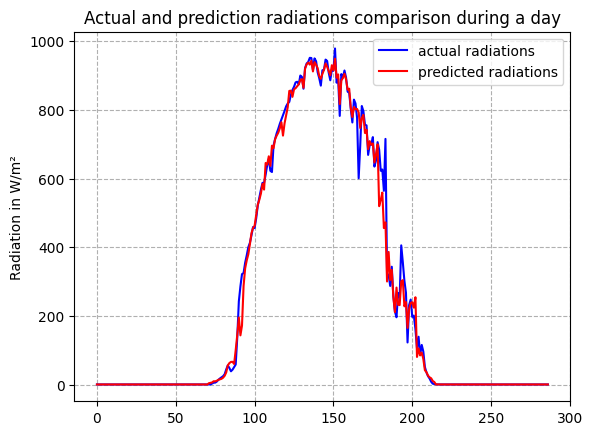

In [28]:
plt.plot(y_true_day, color = 'blue', label = 'actual radiations')
plt.plot(y_pred_day, color = 'red', label = 'predicted radiations')
plt.grid(True, linestyle = '--')
plt.ylabel('Radiation in W/m²')
plt.legend(loc = 'best')
plt.title('Actual and prediction radiations comparison during a day')
plt.show()

### Perspectives for improvements

- Try different hyperparameters / features to reach a R² score higher than current score of 92.5%
- Try other models and see how they perform : XGBM, (Deep) Neural Network ...
- Find a way to have only unseen examples when plotting model performances